### Widenet with feature attention.

##### This notebook is a CNN for CIFAR-10 Classification. Comprehensive detailing of the architecture is available in the associated readme.

Cell 1 - Dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import torch
import torch.nn.utils as nn_utils
import torchvision.transforms as transforms
import torchvision
import math
from torchvision import transforms as tt
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from google.colab.patches import cv2_imshow
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import RandomHorizontalFlip

Cell 2 - Appropriately setting the device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


## Loading, Preprocessing and Augmentation

Cell 3 - This cell defines a Cutout class, an augmentation technique which randomly masks out one or more square regions of an input image to enhance model robustness and generalisability

In [3]:
## doi.org/10.48550/arXiv.1708.04552
## https://github.com/uoguelph-mlrg/Cutout/blob/master/util/cutout.py
class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

Cell 4 - The following cell computes the mean and standard deviation of CIFAR-10 for normalization, applies data augmentations, and prepares DataLoader instances for training, validation, and testing.

In [4]:
# derive mean and stdev
def calculate_stats(dataset):
    loader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=2)
    channel_sum, channel_sum_squared, num_batches = 0, 0, 0

    for data, _ in loader:
        channel_sum += torch.mean(data, dim=[0, 2, 3])
        channel_sum_squared += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channel_sum / num_batches
    std = (channel_sum_squared / num_batches - mean ** 2) ** 0.5
    return mean, std

def load_cifar10_data():
    # load dataset with minimal transformation for stats
    initial_transform = tt.Compose([tt.ToTensor()])
    train_data_initial = CIFAR10(root='./data', train=True, download=True, transform=initial_transform)

    # calculate means and std dev on training set only, to mitigate look-ahead bias.
    mean, std = calculate_stats(train_data_initial)
    print(f"Mu: {mean}, Sigma: {std}")

    # define transformations
    train_transform = tt.Compose([
        tt.RandomRotation(5),
        tt.RandomCrop(32, padding=2, padding_mode='reflect'),
        tt.RandomHorizontalFlip(),
        tt.ToTensor(),
        tt.Normalize(mean=mean, std=std),
        Cutout(n_holes=1, length=10)
    ])

    test_transform = tt.Compose([
        tt.ToTensor(),
        tt.Normalize(mean=mean, std=std)
    ])

    # load the dataset with transformations for training and testing
    train_data = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_data = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    return train_data, test_data, mean, std

train_data, test_data, mean, std = load_cifar10_data()

# creating DataLoaders
train_iter = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_iter = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 170498071/170498071 [00:06<00:00, 27909952.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Mu: tensor([0.4914, 0.4822, 0.4465]), Sigma: tensor([0.2470, 0.2435, 0.2616])
Files already downloaded and verified
Files already downloaded and verified


Cell 5 - Batch Request

In [5]:
X, y = next(iter(train_iter))
print(X.size())
print(y.size())

torch.Size([128, 3, 32, 32])
torch.Size([128])


Cell 6 - This cell displays the first three images from CIFAR-10 with class labels.


Image 0 (dog):



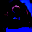


Image 1 (automobile):



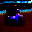


Image 2 (cat):



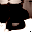

In [6]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(3):
    print(f'\nImage {i} ({class_labels[int(y[i])]}):\n')
    cv2_imshow(X[i].numpy().transpose(1, 2, 0) * 255)

## Required Blocks

Cell 7 - The code below includes blocks that process inputs permitting parallel convolutional layers with varying kernel sizes, implementing what I have called a 'WeightedSum' class that assists in combining outputs based on learned importance weights.

In [7]:
# this class of functions permits the pseudo-attention mechanism
class WeightedSum(nn.Module):
    def __init__(self, num_outputs):
        super(WeightedSum, self).__init__()
        self.fc = None
        self.num_outputs = num_outputs

    def forward(self, x, outputs):
        if self.fc is None:
            self.fc = nn.Linear(x.size(1), self.num_outputs).to(x.device)

        # compute the average value of each channel in x
        avg_per_channel = torch.mean(x, dim=[2, 3])

        # compute the weight vector a
        a = torch.sigmoid(self.fc(avg_per_channel))

        x_prime = torch.zeros_like(outputs[0])

        for i, output in enumerate(outputs):
            scaling_factor = a[:, i].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            x_prime += output * scaling_factor

        return x_prime

class IntermediateBlock(nn.Module): # intermediate blocks with parallel layers
    def __init__(self, input_channels, output_channels, kernel_sizes, strides, paddings):
        super(IntermediateBlock, self).__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(input_channels, output_channels, ks, s, p),
                nn.BatchNorm2d(output_channels), nn.ReLU(), nn.Dropout(0.2)
            ) for ks, s, p in zip(kernel_sizes, strides, paddings)
        ])
        self.weighted_sum = WeightedSum(num_outputs=len(self.layers))

    def forward(self, x):
        outputs = [layer(x) for layer in self.layers]
        x_prime = self.weighted_sum(x, outputs)
        return x_prime

class IntermediateBlockTypeA(IntermediateBlock):
    def __init__(self, input_channels, output_channels):
        super(IntermediateBlockTypeA, self).__init__(
            input_channels, output_channels, [3, 5], [1, 1], [1, 2]
            )

class IntermediateBlockTypeB(IntermediateBlock):
    def __init__(self, input_channels, output_channels):
        super(IntermediateBlockTypeB, self).__init__(
            input_channels, output_channels, [3, 7, 5, 6], [2, 2, 2, 2], [1, 3, 2, 2]
            )


## Additional Blocks

Cell 8 - This defines a ResNet block with a shortcut connection

In [8]:
class ResNet(nn.Module):  # ResNet block
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(output_channels), nn.ReLU(), nn.Dropout(0.2),
            nn.Conv2d(output_channels, output_channels, 3, stride, 1, bias=True),
            nn.BatchNorm2d(output_channels), nn.ReLU(), nn.Dropout(0.2),
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 1, stride, bias=True)
        ) if stride != 1 or input_channels != output_channels else nn.Sequential()

    def forward(self, x):
        out = self.seq(x)
        shortcut = self.shortcut(x)
        out += shortcut
        return out

## Required Output Block

Cell 9 - Output block, averaging each channel of the input, flattening it to a vector, and applying a FLC to result in a logits vector.

In [9]:
class OutputBlock(nn.Module):
    def __init__(self, input_channels, num_outputs):
        super(OutputBlock, self).__init__()
        # initialise FCLs according to # of channels
        self.linear = nn.Linear(input_channels, num_outputs)

    def forward(self, x):
        # compute avg of each channel in x and flatten to form vector m
        m = F.avg_pool2d(x, kernel_size=x.size()[2:]).squeeze(-1).squeeze(-1)
        o = self.linear(m)
        return o

## High-level architecture

Cell 10 - This class outlines the structure of the neural network.

In [10]:
class RobNet(nn.Module):
    def __init__(self, num_outputs):
        super(RobNet, self).__init__()

        self.first_block = IntermediateBlockTypeA(3, 8) # input layer

        self.intermediate_blocks = nn.Sequential(
            IntermediateBlockTypeB(8, 64),
            IntermediateBlockTypeA(64, 256),
        )

        self.resnet_blocks = nn.Sequential(
            ResNet(256, 512, stride=2),
            ResNet(512, 1024, stride=1),
            ResNet(1024, 1024, stride=2), # width is all you need
            ResNet(1024, 256, stride=1),
        )

        self.output_block = OutputBlock(input_channels=256, num_outputs=num_outputs)

    def forward(self, x):
        x = self.first_block(x)
        x = self.intermediate_blocks(x)
        x = self.resnet_blocks(x)
        x = self.output_block(x)
        return x

## Optimiser, Loss Function params


Cell 11 - Initialising the model with output # and loss related parameters.

In [11]:
num_outputs = 10

# nesterov momentum w/ SGD
model = RobNet(num_outputs=num_outputs).to(device)
optimizer = torch.optim.SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=0.0001,
        nesterov=True
        )

loss_fn = torch.nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: math.exp(-0.06 * epoch)) # gradual LR decay

## Training and Evaluation

Cell 12 - This executes the training loop, calculating and updating loss & accuracy for training and validation sets per epoch, applying gradient clipping and adjusting the learning rate per epoch.

In [12]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1)
    return (y_hat == y).float().sum()

def train_and_evaluate(model, optimizer, loss_fn, train_iter, test_iter, device, num_epochs=1, scheduler=None):
    train_accuracies, test_accuracies, train_losses, test_losses, batch_losses = [], [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss_sum, train_correct, n_train = 0.0, 0.0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss = loss_fn(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.7)
            optimizer.step()

            batch_loss = loss.item() * X.size(0)
            train_loss_sum += batch_loss
            train_correct += correct(logits, y).item()
            n_train += y.size(0)
            batch_losses.append(loss.item())

        if scheduler:
            scheduler.step()

        train_loss = train_loss_sum / n_train
        train_losses.append(train_loss)
        train_accuracy = train_correct / n_train
        train_accuracies.append(train_accuracy)

        model.eval()
        test_loss_sum, test_correct, n_test = 0.0, 0.0, 0
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                loss = loss_fn(logits, y)

                test_loss_sum += loss.item() * X.size(0)
                test_correct += correct(logits, y).item()
                n_test += y.size(0)

        test_loss = test_loss_sum / n_test
        test_losses.append(test_loss)
        test_accuracy = test_correct / n_test
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch + 1} | Training: Loss {train_loss:.4f}, Accuracy {train_accuracy:.4f}; Test: Loss {test_loss:.4f}, Accuracy {test_accuracy:.4f}')

    return train_accuracies, test_accuracies, train_losses, test_losses, batch_losses

train_accuracies, test_accuracies, train_losses, test_losses, batch_losses = train_and_evaluate(
    model, optimizer, loss_fn, train_iter, test_iter, device, 50, scheduler)


Epoch 1 | Training: Loss 1.5301, Accuracy 0.4364; Test: Loss 1.2872, Accuracy 0.5474
Epoch 2 | Training: Loss 1.1425, Accuracy 0.5899; Test: Loss 1.3242, Accuracy 0.5614
Epoch 3 | Training: Loss 0.9752, Accuracy 0.6540; Test: Loss 0.8514, Accuracy 0.7047
Epoch 4 | Training: Loss 0.8620, Accuracy 0.6968; Test: Loss 0.7979, Accuracy 0.7270
Epoch 5 | Training: Loss 0.7804, Accuracy 0.7267; Test: Loss 0.6634, Accuracy 0.7631
Epoch 6 | Training: Loss 0.7180, Accuracy 0.7477; Test: Loss 0.6856, Accuracy 0.7651
Epoch 7 | Training: Loss 0.6675, Accuracy 0.7653; Test: Loss 0.5780, Accuracy 0.8009
Epoch 8 | Training: Loss 0.6275, Accuracy 0.7811; Test: Loss 0.7018, Accuracy 0.7660
Epoch 9 | Training: Loss 0.5924, Accuracy 0.7921; Test: Loss 0.5584, Accuracy 0.8082
Epoch 10 | Training: Loss 0.5590, Accuracy 0.8049; Test: Loss 0.5459, Accuracy 0.8186
Epoch 11 | Training: Loss 0.5355, Accuracy 0.8124; Test: Loss 0.5059, Accuracy 0.8287
Epoch 12 | Training: Loss 0.5055, Accuracy 0.8230; Test: Loss 0

Cell 13 - The below expresses the losses per epoch.

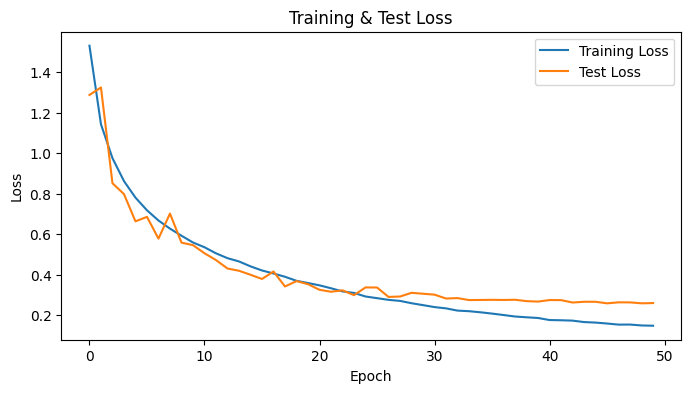

In [13]:
plt.figure(figsize=(8, 4))

# training & test loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Test Loss')
plt.legend()

plt.show()

Cell 14 - The below expresses the accuracies per epoch and the loss per training batch.

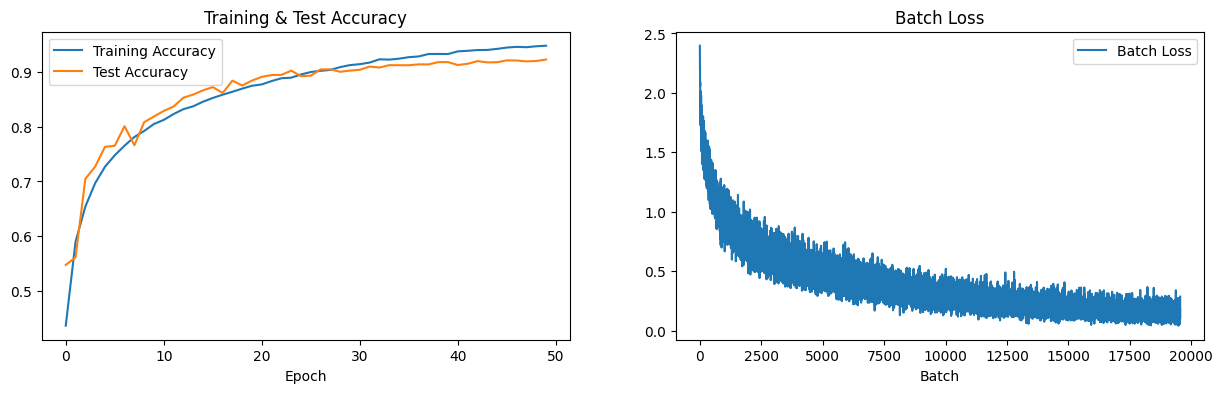

In [14]:
plt.figure(figsize=(15, 4))

# training & test accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.title('Training & Test Accuracy')
plt.legend()

# batch loss
plt.subplot(1, 2, 2)
plt.plot(batch_losses)
plt.xlabel('Batch')
plt.title('Batch Loss')
plt.legend(['Batch Loss'])

plt.show()